## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import TumorDecon as td
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

## Data

In [2]:
lm22 = pd.read_csv("../data/LM22_source_GEPs.txt",delimiter="\t",index_col="genesinput")
lm22.shape

(11845, 22)

In [3]:
lm22_small = pd.read_csv("../data/LM22.txt",delimiter="\t",index_col="Gene symbol")
lm22_small.head()

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
Gene symbol,,,,,,,,,,,,,,,,,,,,,
ABCB4,555.713449,10.744235,7.225819,4.311280,4.605860,7.406442,8.043976,6.469993,7.833082,9.312295,...,6.202496,7.951360,27.557710,121.432277,114.636747,4.872184,4.727985,34.113659,15.030530,14.906888
ABCB9,15.603544,22.094787,653.392328,24.223723,35.671507,30.048192,38.455423,17.604795,46.073657,19.715722,...,20.309426,56.251887,29.380878,40.390260,123.993305,23.384603,53.466757,23.615746,29.786442,33.679147
ACAP1,215.305951,321.621021,38.616872,1055.613378,1790.097170,922.152747,340.883424,1107.798265,1995.482601,280.075719,...,190.879024,48.972217,30.974254,23.055150,61.386550,26.412923,104.200198,73.607932,696.442802,596.025961
ACHE,15.117949,16.648847,22.123737,13.428288,27.187732,18.444927,13.441268,14.805542,24.652712,33.658448,...,16.375268,13.692963,1373.069620,48.585761,16.715474,193.159977,13.948778,20.501249,40.414927,22.766494
ACP5,605.897384,1935.201479,1120.104684,306.312519,744.656599,557.819820,248.546932,711.949744,958.916018,493.969120,...,512.931382,13644.172300,1062.475909,7633.960182,13825.053630,3989.865169,263.497930,323.381277,860.563374,307.142798


In [265]:
def generate_samples(num_samples, lm22, max_dropout=.2):
    generated_x = np.zeros((num_samples,11845))
    generated_y = np.zeros((num_samples,22))
    lm22_values = lm22.values
    number_of_each_cell = np.random.randint(0,15,size=(num_samples, 22))
    
    for i in range(num_samples):
        generated_x[i] = np.sum(lm22_values*number_of_each_cell[i], axis=1)
        indices = np.random.choice(np.arange(11845), replace=False,
                           size=int(11845 * np.random.uniform(max_dropout)))
        generated_x[i][indices] = 0
        generated_y[i] = number_of_each_cell[i]/np.sum(number_of_each_cell[i])
    
    
    
    g_min = generated_x.min(axis=0)
    generated_x =(generated_x - g_min) / (generated_x.max(axis=0) - g_min)
    return generated_x, generated_y
    
def format_input(expression_df, lm22):
    return

In [266]:
m = tf.keras.Sequential()
m.add(tf.keras.layers.Dense(1024,  activation='elu', input_shape=(11845,)))
m.add(tf.keras.layers.Dense(512,  activation='elu'))
m.add(tf.keras.layers.Dense(256,  activation='elu'))
m.add(tf.keras.layers.Dense(128,    activation='linear', name="bottleneck"))
m.add(tf.keras.layers.Dense(256,  activation='elu'))
m.add(tf.keras.layers.Dense(512,  activation='elu'))
m.add(tf.keras.layers.Dense(1024,  activation='elu'))
m.add(tf.keras.layers.Dense(11845,  activation='sigmoid'))
m.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam(),metrics=['mse'])


m2 = tf.keras.Sequential()
m2.add(tf.keras.layers.Dense(128,  activation='elu', input_shape=(11845,)))
m2.add(tf.keras.layers.Dense(128,  activation='elu'))
m2.add(tf.keras.layers.Dense(22,    activation='linear'))
m2.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam(),metrics=['mse'])

In [267]:
X,Y = generate_samples(100000,lm22,max_dropout=0.2)

In [231]:
#td.cell_frequency_barchart(pd.DataFrame(data=Y,columns=lm22_small.columns))

## Models
The generated data looks pretty good so now I am going to move onto modeling and making an auto encoder to reduce the dimensionality of the data. Then I will train a neural net totake in the reduced vector and predict immune cell fractions

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [269]:
X_train.shape

(90000, 11845)

In [260]:
history = m.fit(X_train, X_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, X_test))

encoder = tf.keras.Model(m.input, m.get_layer('bottleneck').output)
Zenc = encoder.predict(X_train)  # bottleneck representation
Renc = m.predict(X_train)        # reconstruction

Train on 18000 samples, validate on 2000 samples
Epoch 1/10
18000/18000 [==============================] - 4s 223us/sample - loss: 0.0794 - mse: 0.0794 - val_loss: 0.0781 - val_mse: 0.0781
Epoch 2/10
18000/18000 [==============================] - 4s 221us/sample - loss: 0.0792 - mse: 0.0792 - val_loss: 0.0781 - val_mse: 0.0781
Epoch 3/10
18000/18000 [==============================] - 4s 220us/sample - loss: 0.0794 - mse: 0.0794 - val_loss: 0.0780 - val_mse: 0.0780
Epoch 4/10
18000/18000 [==============================] - 4s 218us/sample - loss: 0.0791 - mse: 0.0791 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 5/10
18000/18000 [==============================] - 4s 221us/sample - loss: 0.0794 - mse: 0.0794 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 6/10
18000/18000 [==============================] - 4s 221us/sample - loss: 0.0790 - mse: 0.0790 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 7/10
18000/18000 [==============================] - 4s 219us/sample - loss: 0.0790 - mse: 0.0790 - val_lo

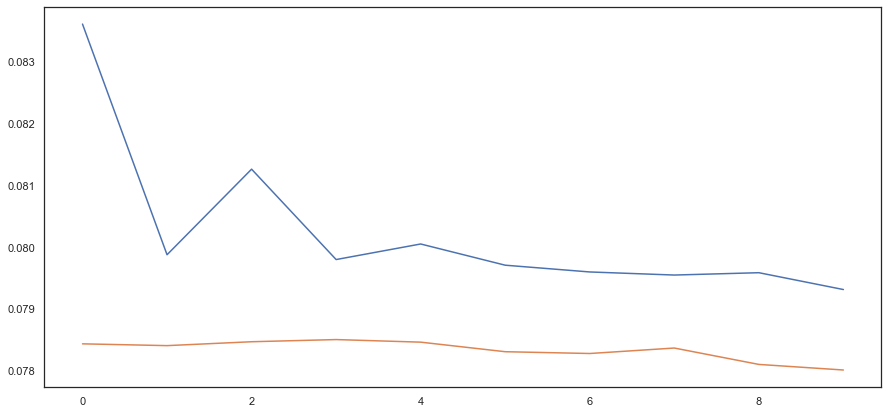

In [235]:
plt.plot(history.history['mse'], label='root_mean_squared_error')    #blue
plt.plot(history.history['val_mse'], label = 'val_root_mean_squared_error') 

In [272]:
history = m2.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, y_test))

Train on 90000 samples, validate on 10000 samples
Epoch 1/10
90000/90000 [==============================] - 7s 83us/sample - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 2/10
90000/90000 [==============================] - 7s 74us/sample - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 3/10
90000/90000 [==============================] - 7s 74us/sample - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 4/10
90000/90000 [==============================] - 7s 74us/sample - loss: 0.0012 - mse: 0.0012 - val_loss: 9.5487e-04 - val_mse: 9.5487e-04
Epoch 5/10
90000/90000 [==============================] - 7s 75us/sample - loss: 8.6666e-04 - mse: 8.6666e-04 - val_loss: 9.4741e-04 - val_mse: 9.4741e-04
Epoch 6/10
90000/90000 [==============================] - 7s 75us/sample - loss: 7.6228e-04 - mse: 7.6228e-04 - val_loss: 8.2357e-04 - val_mse: 8.2357e-04
Epoch 7/10
90000/90000 [==============================] - 7s 74us/sample - l

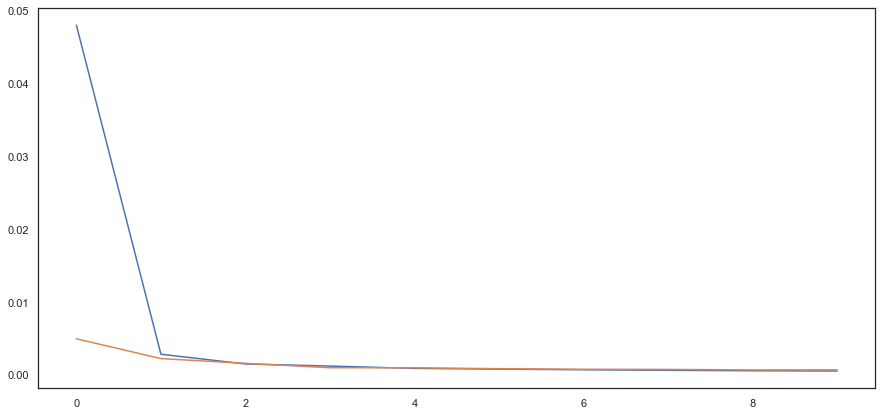

In [273]:
plt.plot(history.history['mse'], label='root_mean_squared_error')    #blue
plt.plot(history.history['val_mse'], label = 'val_root_mean_squared_error') 

In [275]:
to_compare = m2.predict(X_test[:50])
nn_results_df = pd.DataFrame(data=to_compare,columns=lm22_small.columns)

In [276]:
test_df = pd.DataFrame(data=X_test[:50],columns=lm22.index)
cibersort_results = td.cibersort_main(test_df.T,lm22_small).fillna(0)

Running CiberSort...


In [277]:
test_df.head()

genesinput,A1CF,A2M,A4GALT,A4GNT,AAAS,AACS,AADAC,AAGAB,AAK1,AAMP,...,ZSCAN5A,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
0,0.000000,0.000000,0.000000,0.000000,0.677995,0.614976,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.630954,0.617998,0.000000,0.000000,0.435543,0.000000,0.000000,0.000000
1,0.000000,0.518333,0.396843,0.000000,0.501204,0.000000,0.000000,0.538267,0.000000,0.499103,...,0.000000,0.534366,0.000000,0.576927,0.000000,0.527947,0.000000,0.585227,0.537639,0.000000
2,0.623451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.651017,0.000000,0.000000,0.000000,0.000000,0.590676,0.000000,0.000000,0.000000,0.000000
3,0.641340,0.000000,0.000000,0.000000,0.000000,0.607402,0.633694,0.000000,0.660361,0.000000,...,0.686045,0.608429,0.000000,0.000000,0.572091,0.000000,0.553254,0.000000,0.000000,0.646853
4,0.465915,0.566938,0.519009,0.446114,0.498162,0.460528,0.000000,0.515913,0.000000,0.508233,...,0.438356,0.000000,0.517326,0.000000,0.485351,0.000000,0.370861,0.000000,0.494380,0.441230


## Comparting Predictions

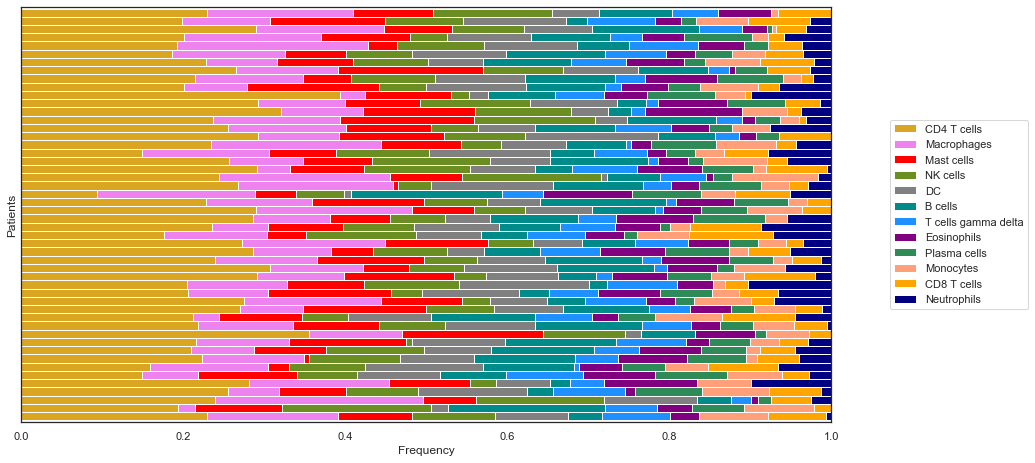

In [278]:
td.cell_frequency_barchart(pd.DataFrame(data=Y[:50],columns=lm22_small.columns))

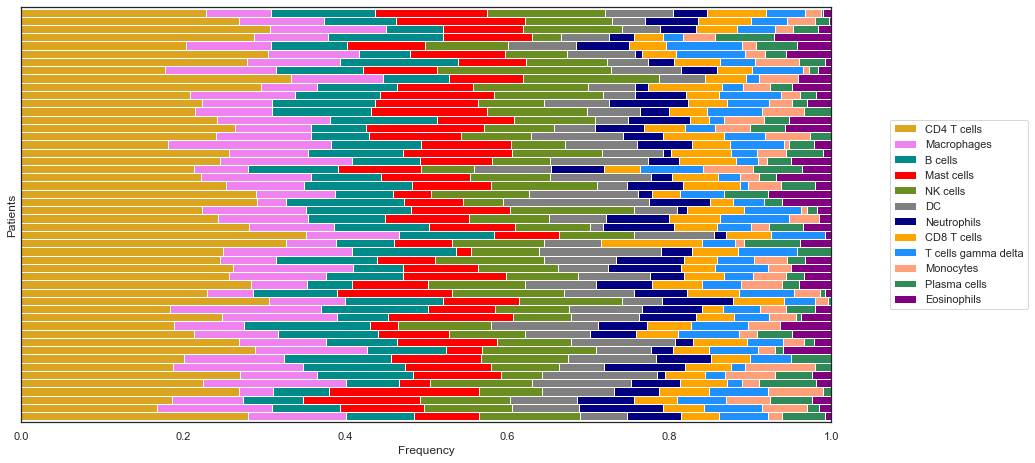

In [279]:
td.cell_frequency_barchart(nn_results_df)

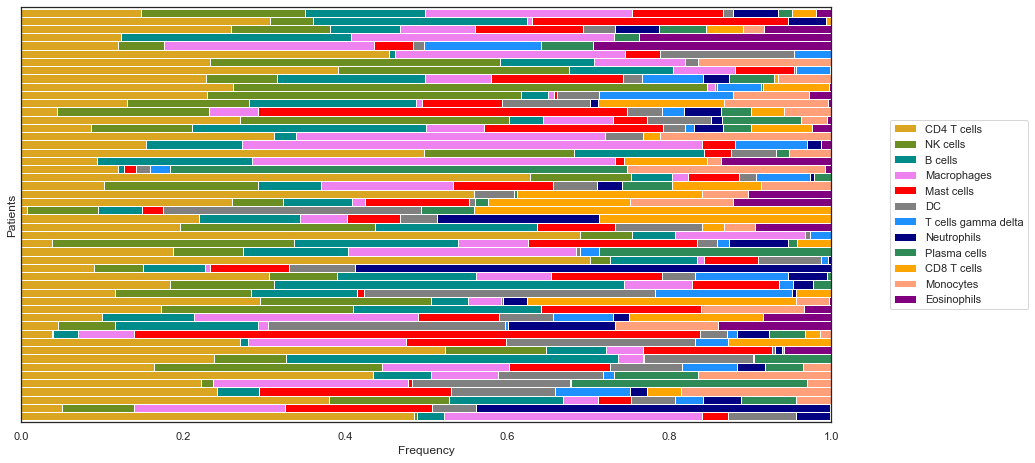

In [280]:
td.cell_frequency_barchart(cibersort_results)

In [281]:
nn_comb = td.combine_celltypes(nn_results_df)
c_comb = td.combine_celltypes(cibersort_results).fillna(0)
y_comb = td.combine_celltypes(pd.DataFrame(data=Y[:50],columns=lm22_small.columns))

0.7199410985989071

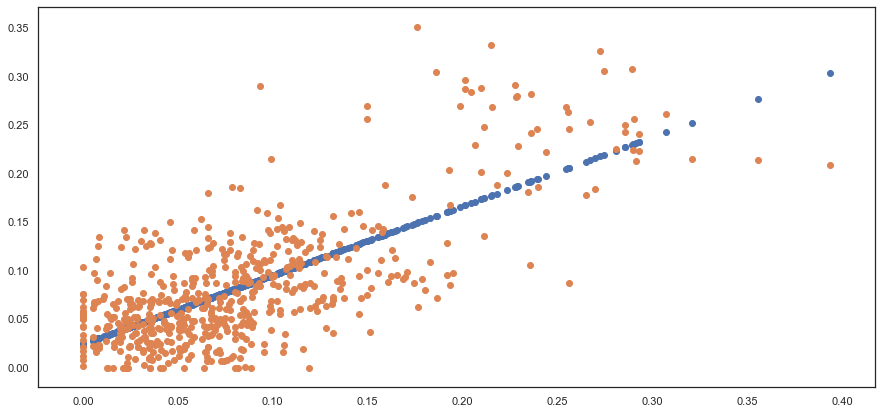

In [282]:
lin = LinearRegression().fit(y_comb.values.flatten().reshape(-1, 1),nn_comb.values.flatten().reshape(-1, 1))
plt.scatter(y_comb.values.flatten().reshape(-1, 1),lin.predict(y_comb.values.flatten().reshape(-1, 1)))
plt.scatter(y_comb.values,nn_comb.values)
lin.score(y_comb.values.flatten().reshape(-1, 1),nn_comb.values.flatten().reshape(-1, 1))**.5

0.381188758247987

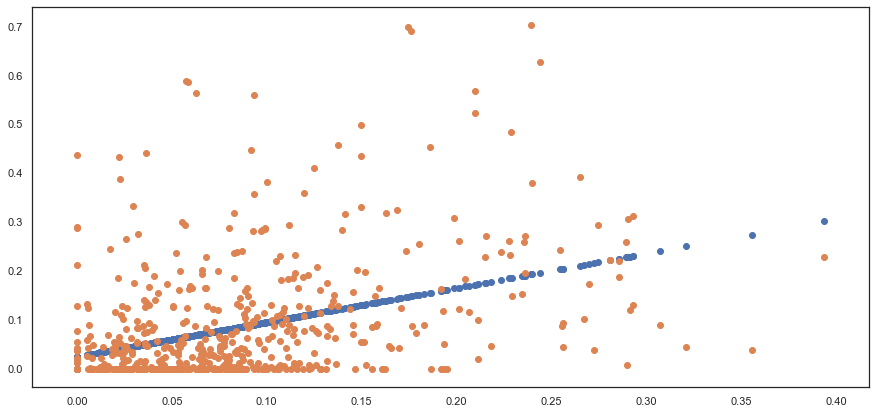

In [283]:
lin = LinearRegression().fit(y_comb.values.flatten().reshape(-1, 1),c_comb.values.flatten().reshape(-1, 1))
plt.scatter(y_comb.values.flatten().reshape(-1, 1),lin.predict(y_comb.values.flatten().reshape(-1, 1)))
plt.scatter(y_comb.values,c_comb.values)
lin.score(y_comb.values.flatten().reshape(-1, 1),c_comb.values.flatten().reshape(-1, 1))**.5

In [284]:
print("NN MAE:",mean_absolute_error(y_comb.values,nn_comb.values))
print("CIBERSORT MAE:",mean_absolute_error(y_comb.values,c_comb.values))

NN MAE: 0.037881225487882385
CIBERSORT MAE: 0.07682508245066541


## Bring in Other Test Data

In [167]:
cibersort_gep = pd.read_csv("C:/Users/NathanGrant/Programs/TripodsREU/data/ExampleMixtures-GEPs.txt",delimiter="\t",index_col="Hugo_Symbol")
cibersort_gep.shape

(11866, 5)

In [256]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')